# Final Assignment MLiM - WS 20/21

## Import Packages

TO DO: 

* Please reassign your corresponding paths
    * Set path where data sets are stored; newly created data sets will also be stored there
    * Set path to where the module is stored; this path will also be used to store the results

In [12]:
'TO DO: Please reassign your corresponding paths:'

#set path where data sets are stored
path_datasets = '/Users/Bisa/Desktop/mlim_13/final_assignment'
#set path to where the module is stored
%cd '/Users/Bisa/Desktop/mlim_13/final_assignment'

/Users/Bisa/Desktop/mlim_13/final_assignment


In [13]:
# data wrangling 
import pandas as pd
import numpy as np
import time

# feature engineering 
import module_p2v
from module_clustering import p2cluster

import module_negatives

import module_lags

import module_generate_dataset 
from module_generate_dataset import generate_dataset

# train-test-splitting
import module_train_test_splitting
from module_train_test_splitting import train_test_splitting

# heuristic model 
import module_baseline_heuristic_model
# modeling 
import lightgbm as lgbm
import xgboost as xgb
import pickle

import module_lightgbm
from module_lightgbm import predict_lightgbm

# generate data set for week 90
import module_week90_generate_dataset
from module_week90_generate_dataset import week90_generate_dataset

# evaluation 
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss

# visualiation
import matplotlib.pyplot as plt
import seaborn as sns

# coupon recommendations 
import module_coupon_assignment 
from module_coupon_assignment import coupon_assignment

## Data Set Creation and Feature Engineering

### Basket Generation 

In [ ]:
df_baskets = pd.read_parquet(path_datasets + "/baskets.parquet")

In [34]:
# calculate weekly item list per shopper 
def create_baskets(input_purchases):
    """Calculate an item list of products per shopper per week"""
    input_origin = input_purchases.copy()
    input_purchases = (
        input_purchases.groupby(by=["shopper", "week"])
        .agg({"product": lambda x: list(x), "price": sum})
        .reset_index(drop=False)
    )
    input_purchases = input_purchases.rename(columns={"product": "products"})
    input_purchases["basket_size"] = input_purchases["products"].apply(len)
    return input_purchases, input_origin

baskets, _ = create_baskets(df_baskets)
baskets.head()

,shopper,week,products,price,basket_size
0,0,0,"[71, 91, 116, 123, 157, 167, 171, 184, 207, 225]",5908,10
1,0,1,"[71, 91, 130, 157, 167, 191, 225]",4109,7
2,0,2,"[52, 67, 71, 87, 91, 130, 184, 211, 238]",5108,9
3,0,3,"[71, 91, 123, 130, 179, 184, 214, 225]",4681,8
4,0,4,"[48, 67, 76, 91, 116, 123, 184, 225]",4740,8


### Categories Generation

In [47]:
# train p2v model
product_vector_model = module_p2v.p2v(baskets["products"])
product_vector_model.create_product_list()

product_vector_model.train_p2v(vec_dim=30, epochs=100)

Epoch #0
Epoch #5
Epoch #10
Epoch #15
Epoch #20
Epoch #25
Epoch #30
Epoch #35
Epoch #40
Epoch #45
Epoch #50
Epoch #55
Epoch #60
Epoch #65
Epoch #70
Epoch #75
Epoch #80
Epoch #85
Epoch #90
Epoch #95


In [430]:
product_vector_model.get_insights(20)

30-dimensional vector for 20:
[ 16.91958     11.792615   -21.050528     7.352144     7.255684
   1.0665644    9.210043    -4.9053097    5.138174    -1.5399554
 -15.364899    -2.210627     1.158818     4.2922053    5.387418
   3.9973686   14.811209    -0.83350635   7.518798     5.9882135
 -11.342001     3.9756105  -16.87106      2.4546146   -3.8887858
 -10.50681      5.9898324    7.0195384   -4.0393276    7.58036   ]

Most similar products for 20:
[('29', 0.6650466322898865), ('23', 0.6482033729553223), ('22', 0.6268254518508911), ('27', 0.6112769246101379), ('25', 0.6083812713623047), ('21', 0.5770205855369568), ('26', 0.5235933065414429), ('28', 0.4557826519012451), ('24', 0.44312116503715515), ('232', 0.3516092002391815)]


In [118]:
# save backup
# with open("product_vector_model.pickle", "wb") as handle:
#     pickle.dump(product_vector_model, handle)

In [4]:
# with open("product_vector_model.pickle", "rb") as handle:
#     product_vector_model = pickle.load(handle)

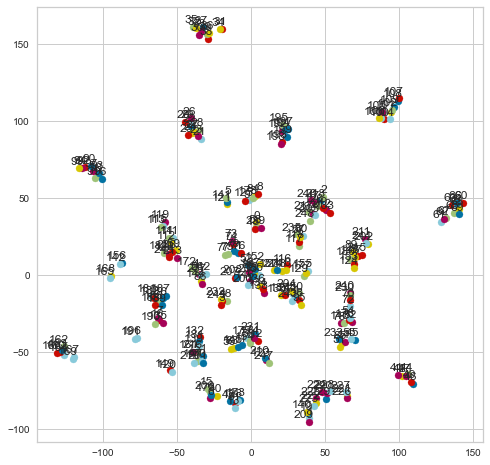

In [85]:
p2cluster_model = p2cluster(product_vector_model.p2v_model)
p2cluster_model.tsne_train()
p2cluster_model.tsne_plot()

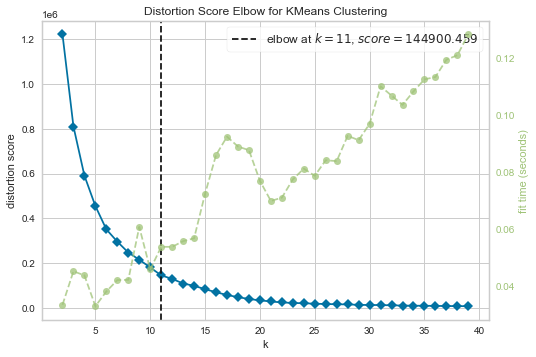

In [86]:
p2cluster_model.elbow_plot()

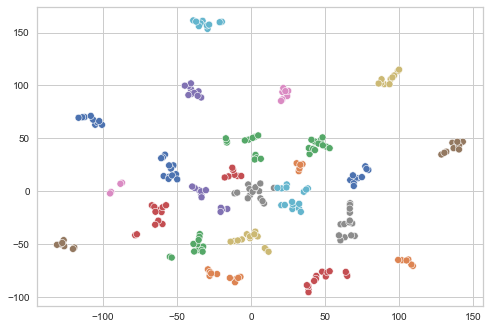

In [87]:
# set to 25 clusters
p2cluster_model.train_cluster(25)
p2cluster_model.clust_plot()

In [267]:
product_categories = p2cluster_model.get_categories()
product_categories.head()

,tsne_x,tsne_y,product,category_label
76,3.079960,34.391747,0,12
65,38.935280,-93.043007,1,3
175,48.395184,50.941959,2,22
206,-20.546894,-19.471403,3,24
37,-37.980141,3.057139,4,14


In [312]:
product_categories[["product", "category_label"]].to_csv(
    "product_categories.csv", index=False
)

### Preferences & Negative Samples

In [109]:
# with open("baskets_product_list.pickle", "rb") as handle:
#     baskets = pickle.load(handle)

In [110]:
# set to 0..1999 shoppers, since the final prediction only assigns coupons to these shoppers
baskets = baskets[baskets["shopper"]<2000]
baskets

,shopper,week,products,price,basket_size
0,0,0,"[71, 91, 116, 123, 157, 167, 171, 184, 207, 225]",5908,10
1,0,1,"[71, 91, 130, 157, 167, 191, 225]",4109,7
2,0,2,"[52, 67, 71, 87, 91, 130, 184, 211, 238]",5108,9
3,0,3,"[71, 91, 123, 130, 179, 184, 214, 225]",4681,8
4,0,4,"[48, 67, 76, 91, 116, 123, 184, 225]",4740,8
...,...,...,...,...,...
179961,1999,85,"[21, 48, 86, 144, 158, 168, 192]",3674,7
179962,1999,86,"[4, 41, 64, 103, 132, 158, 220, 242]",4727,8
179963,1999,87,"[31, 47, 50, 64, 86, 103, 158, 168, 194]",5344,9
179964,1999,88,"[18, 47, 64, 144, 158, 168, 170, 192]",4712,8


In [104]:
# calculate the total frequencies of product purchases per shopper per product
negative_sampler = module_negatives.NegativeSampleGenerator(baskets,no_customers=2000)
negative_sampler.calculate_frequencies()
negative_sampler.get_total_frequency_without89()

array([[ 0,  0,  0, ...,  0,  0, 13],
       [ 6, 13,  0, ...,  0,  0,  6],
       [ 0, 46,  0, ...,  0,  9,  5],
       ...,
       [ 0,  1,  0, ...,  0,  0,  6],
       [ 0,  1,  1, ...,  1, 38,  0],
       [ 0,  3,  0, ...,  0, 31,  0]], dtype=int8)

In [111]:
# based on the frequencies: calculate the shopperXproduct combinations with a minimum purchase count of >=3
preferences = negative_sampler.calculate_customer_preferences(min_frequency=3)
negative_sampler.show_customer_preferences(2)

0:
[4, 11, 16, 38, 52, 56, 67, 71, 76, 81, 87, 91, 110, 116, 123, 130, 148, 157, 167, 171, 179, 181, 184, 191, 202, 207, 210, 211, 214, 225, 238, 244, 249]
1:
[0, 1, 4, 21, 22, 28, 33, 35, 36, 39, 42, 48, 50, 53, 63, 78, 83, 92, 94, 111, 116, 117, 125, 136, 142, 145, 146, 149, 156, 165, 168, 171, 182, 183, 189, 193, 199, 200, 209, 211, 212, 220, 228, 229, 235, 249]


In [107]:
# sample preferences products randomly in the size of the shoppers basket size of this week
df_negative_samples = negative_sampler.generate()

0% done.
10% done.
20% done.
30% done.
40% done.
50% done.
60% done.
70% done.
80% done.
90% done.
100% done.


In [108]:
df_negative_samples.head()

,week,shopper,product,product_bought
0,0,0,238,0
1,0,0,16,0
2,0,0,130,0
3,0,0,181,0
4,0,0,52,0


In [ ]:
df_negative_samples.to_parquet("df_negative_samples.parquet")

In [315]:
# with open("preferences_min3.pickle", "wb") as handle:
#     pickle.dump(preferences, handle)

In [34]:
# with open("df_negative_samples.pickle", "wb") as handle:
#     pickle.dump(df_negative_samples, handle)

### Product Sampling (Week 90)

In [3]:
# with open("preferences_min3.pickle", "rb") as handle:
#     consumers_preferences = pickle.load(handle)

In [113]:
consumers_preferences = negative_sampler.cons_preferences

In [4]:
# sample all preferenced products with min_frequency >=3 per shopper for week 90
def create_week_90_products():
    df_90 = pd.DataFrame(columns=["week", "shopper", "product", "product_bought"])
    for customer in range(2000):
        for pref in consumers_preferences[customer]:
            df_90 = df_90.append({"week": 90 ,
                                 "shopper": customer,
                                 "product": pref,
                                 "product_bought":0},ignore_index=True)
    return df_90

df_90 = create_week_90_products()

In [6]:
df_90["shopper"].nunique()

2000

In [7]:
df_90.to_parquet("df_90.parquet")

### Lagged Features

In [14]:
df_coupons = pd.read_parquet(path_datasets + "/coupons.parquet")
df_full = pd.merge(df_baskets[df_baskets["shopper"]<2000], df_coupons[df_coupons["shopper"]<2000], on=['week', 'shopper', 'product'], how='outer')
df_full['product_bought'] = np.where(df_full['price'].isna(), 0, 1)
df_full = df_full[["week","shopper","product","product_bought"]]
# df_90 = pd.read_parquet("df_90.parquet") # only re-read if required
df_full = pd.concat([df_full, df_90], ignore_index=True)

In [46]:
df_full

,week,shopper,product,product_bought
0,0,0,5,0
1,0,0,16,0
2,0,0,27,0
3,0,0,35,0
4,0,0,52,0
...,...,...,...,...
3665492,90,1999,228,0
3665493,90,1999,237,0
3665494,90,1999,242,0
3665495,90,1999,245,0


In [48]:
purchase_lags = module_lags.LagCalculator(
    df_full[["shopper", "product", "week", "product_bought"]]
    .sort_values(by=["shopper", "product", "week"], ascending=[True, True, True])
    .reset_index(drop=True)
)

In [49]:
lags = purchase_lags.calculate_lags()

0% done.
10% done.
20% done.
30% done.
40% done.
50% done.
60% done.
70% done.
80% done.
90% done.


In [50]:
lags.iloc[3001:3006]

,shopper,product,week,product_bought,lag_weeks_of_product_per_customer
3001,1,146,5,0,4
3002,1,146,7,0,6
3003,1,146,8,0,7
3004,1,146,11,1,10
3005,1,146,12,0,1


In [51]:
# replace "product_bought" of week 90 with NaN's
lags.loc[lags['week']==90,['product_bought']] = np.nan

In [41]:
lags['week'] = lags['week'].astype('int32')
purchase_temporal_distribution = purchase_lags.calculate_purchase_temporal_distribution(lags)
purchase_temporal_distribution.head()

,shopper,product,purchase_temporal_distribution
0,0,4,50.250000
1,0,11,59.666667
2,0,15,10.000000
3,0,16,45.000000
4,0,21,86.000000


In [42]:
avg_no_weeks_between_two_purchases = purchase_lags.calculate_avg_no_weeks_between_two_purchases(lags)
avg_no_weeks_between_two_purchases.head()

,shopper,product,avg_no_weeks_between_two_purchases
0,0,4,5.625000
1,0,11,6.777778
2,0,15,-1.000000
3,0,16,15.500000
4,0,21,-1.000000


In [52]:
# export
lags.to_parquet("lags.parquet")
purchase_temporal_distribution.to_parquet("purchase_temporal_distribution.parquet")
avg_no_weeks_between_two_purchases.to_parquet("avg_no_weeks_between_two_purchases.parquet")

In [44]:
# example
lags[(lags["shopper"]==333) & (lags["week"]==66)]

,shopper,product,week,product_bought,lag_weeks_of_product_per_customer
606545,333,20,66,0.0,-1
606738,333,41,66,0.0,5
606815,333,48,66,0.0,1
606836,333,51,66,0.0,-1
606911,333,60,66,1.0,3
607021,333,80,66,0.0,-1
607302,333,129,66,0.0,8
607341,333,132,66,0.0,6
607401,333,137,66,1.0,3
607500,333,144,66,1.0,12


## Final Data Set Creation 

**In case the data sets are already loaded, proceed with code starting at 'Train-Test-Split'**

* Prerequisites: the following data frames are needed. They shoud be named:
    * baskets.parquet (provided/downloaded)
    * coupons.parquet (provided/downloaded)
    * df_negative_samples.parquet (created)
    * product_categories.csv (created)
    * avg_no_weeks_between_two_purchases.parquet (created)
    * lags.parquet (created)
    * purchase_temporal_distribution.parquet (created)

In [38]:
#the module outputs two dataframes: the train and test dataset
#generate_dataset(path, train_start, train_end, test_start, test_end)

train, test = generate_dataset(path_datasets, 0, 88, 1, 89)

The dataframes should be named: 
baskets.parquet, 
coupons.parquet, 
df_negative_samples.parquet, 
product_categories.csv, 
avg_no_weeks_between_two_purchases.parquet, 
lags.parquet and 
purchase_temporal_distribution.parquet

Data sets (train and test) are generated and saved as a parquet file to: /Users/asmir/mlim_project/mlim/exercises/assignment


In [39]:
train.head()

,week,shopper,product,price,discount,product_bought,category_label,avg_no_weeks_between_two_purchases,lag_weeks_of_product_per_customer,purchase_temporal_distribution,...,customer_prod_bought_dis_share,customer_prod_dis_offers,customer_prod_dis_offered_share,customer_product_share,customer_mean_product_price,customer_discount_buy_share,week_basket_size,week_basket_value,mean_basket_size,mean_basket_value
0,0,0,5,504.7,30.0,0,12,-1.000000,-1.0,-1.000000,...,-1.0,2,0.0,-1.000000,587.203947,0.030263,10.0,5908.0,8.978947,5271.6
1,0,0,16,743.0,0.0,0,13,15.500000,-1.0,45.000000,...,0.5,39,0.5,0.005263,587.203947,0.030263,10.0,5908.0,8.978947,5271.6
2,0,0,27,407.4,30.0,0,4,-1.000000,-1.0,-1.000000,...,-1.0,3,0.0,-1.000000,587.203947,0.030263,10.0,5908.0,8.978947,5271.6
3,0,0,35,391.3,35.0,0,9,-1.000000,-1.0,-1.000000,...,-1.0,3,0.0,-1.000000,587.203947,0.030263,10.0,5908.0,8.978947,5271.6
4,0,0,52,607.0,0.0,0,7,9.111111,-1.0,38.555556,...,0.0,38,0.0,0.011842,587.203947,0.030263,10.0,5908.0,8.978947,5271.6


In [40]:
test.head()

,week,shopper,product,price,discount,product_bought,category_label,avg_no_weeks_between_two_purchases,lag_weeks_of_product_per_customer,purchase_temporal_distribution,...,customer_prod_bought_dis_share,customer_prod_dis_offers,customer_prod_dis_offered_share,customer_product_share,customer_mean_product_price,customer_discount_buy_share,week_basket_size,week_basket_value,mean_basket_size,mean_basket_value
0,1,0,5,468.65,35.0,0,12,-1.000000,-1.0,-1.000000,...,-1.000000,1,0.0,-1.000000,586.607895,0.032895,7.0,4109.0,8.978947,5265.639474
1,1,0,34,635.40,10.0,0,9,-1.000000,-1.0,-1.000000,...,-1.000000,5,0.0,-1.000000,586.607895,0.032895,7.0,4109.0,8.978947,5265.639474
2,1,0,56,570.75,25.0,0,14,23.666667,-1.0,39.000000,...,0.000000,41,0.0,0.003947,586.607895,0.032895,7.0,4109.0,8.978947,5265.639474
3,1,0,71,629.00,0.0,1,23,1.303030,1.0,43.030303,...,0.030303,72,1.0,0.086842,586.607895,0.032895,7.0,4109.0,8.978947,5265.639474
4,1,0,81,513.00,0.0,0,21,6.666667,-1.0,44.666667,...,0.000000,29,0.0,0.003947,586.607895,0.032895,7.0,4109.0,8.978947,5265.639474


### Train-Test-Split

In [41]:
#parameter are path, train_start, train_end, test_start, test_end, eval_set = False
X_train, X_test, y_train, y_test = train_test_splitting(path_datasets, 0, 88, 89, 89, eval_set = False)

The following features will be removed from the data sets (besides the target variable product_bought): 
shopper, 
product, 
purchase_w/o_dis, 
no_purchase_w_dis, \discount_offered, 
discount_effect, 
week_basket_size and 
week_basket_value. 
Among others, reasons are target leakage and non-reproducibility for week 90.
Training Observations: 3540798
Testing Observations: 39535
Observations: 3580333


## Modeling

### Heuristic Model

In [34]:
import importlib
importlib.reload(module_baseline_heuristic_model)

<module 'module_baseline_heuristic_model' from '/Users/asmir/mlim_project/mlim/exercises/assignment/module_baseline_heuristic_model.py'>

**Assumptions**:
1.  A customer will continue buying products with a coupon, if she has done so previously. 

**Logic/Algorithm**:

1. Calculate the rate an item is bought with a coupon for each customer
2. Order the items descending by coupon redemption rate
3. Return the top 5 products
4. Assign a coupon to these products for the week t+1, here week 90

In [31]:
baseline_data = module_baseline_heuristic_model.generate_heuristic_data(path_datasets)

In [35]:
heur_idx = module_baseline_heuristic_model.heuristic_model(path_datasets, baseline_data)

In [36]:
heur_idx.head(n=10)

,shopper,week,coupon,product,discount
0,0,90,0,185,30
1,0,90,1,16,25
2,0,90,2,207,20
3,0,90,3,179,15
4,0,90,4,214,15
5,1,90,0,75,30
6,1,90,1,157,25
7,1,90,2,165,20
8,1,90,3,220,15
9,1,90,4,53,15


### XGBoost

In [29]:
xgb_mtx_train = xgb.DMatrix(X_train, label=y_train)
xgb_mtx_test = xgb.DMatrix(X_test, label=y_test)
params = {'max_depth': 10 , 'eta': 0.01, 'objective': 'binary:logistic', 'eval_metric': 'auc'}
evallist = [(xgb_mtx_test, 'eval'), (xgb_mtx_train, 'train')]
num_round = 100
bst = xgb.train(params, xgb_mtx_train, num_round, evallist)

[0]	eval-auc:0.87180	train-auc:0.87716
[1]	eval-auc:0.87380	train-auc:0.87867
[2]	eval-auc:0.87658	train-auc:0.88059
[3]	eval-auc:0.87848	train-auc:0.88105
[4]	eval-auc:0.87713	train-auc:0.88406
[5]	eval-auc:0.87542	train-auc:0.88546
[6]	eval-auc:0.87281	train-auc:0.88765
[7]	eval-auc:0.87147	train-auc:0.88849
[8]	eval-auc:0.86856	train-auc:0.88967
[9]	eval-auc:0.86607	train-auc:0.89156
[10]	eval-auc:0.86506	train-auc:0.89223
[11]	eval-auc:0.86289	train-auc:0.89261
[12]	eval-auc:0.86272	train-auc:0.89307
[13]	eval-auc:0.86246	train-auc:0.89348
[14]	eval-auc:0.86219	train-auc:0.89374
[15]	eval-auc:0.86144	train-auc:0.89454
[16]	eval-auc:0.86174	train-auc:0.89495
[17]	eval-auc:0.86236	train-auc:0.89516
[18]	eval-auc:0.86191	train-auc:0.89550
[19]	eval-auc:0.86082	train-auc:0.89586
[20]	eval-auc:0.86009	train-auc:0.89612
[21]	eval-auc:0.85902	train-auc:0.89642
[22]	eval-auc:0.85965	train-auc:0.89740
[23]	eval-auc:0.85883	train-auc:0.89794
[24]	eval-auc:0.85996	train-auc:0.89838
[25]	eval-

In [37]:
ypred = bst.predict(xgb_mtx_test)
ytrue = y_test

print("Confusion Matrix: \n", confusion_matrix(list(ytrue),list(ypred>0.5)))

Confusion Matrix: 
 [[21127  3215]
 [ 4546 10647]]


In [35]:
#AUC
print("AUC: ", metrics.auc(fpr, tpr))

AUC:  0.871180772610282


In [34]:
#Logloss
print("Cross Entropy: ", log_loss(list(ytrue), list(ypred)))

Cross Entropy:  0.6767952511705434


### LightGBM

Training until validation scores don't improve for 50 rounds
[200]	training's binary_logloss: 0.411992	training's auc: 0.891586	valid_1's binary_logloss: 0.391143	valid_1's auc: 0.908403
Did not meet early stopping. Best iteration is:
[300]	training's binary_logloss: 0.392153	training's auc: 0.895027	valid_1's binary_logloss: 0.358007	valid_1's auc: 0.91929
defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.3921530708235825), ('auc', 0.8950266281960872)]), 'valid_1': OrderedDict([('binary_logloss', 0.35800743808282914), ('auc', 0.9192897473995523)])})

The computation took 9.42 minutes.


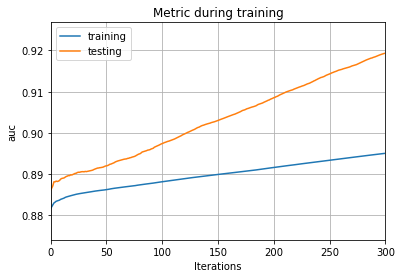

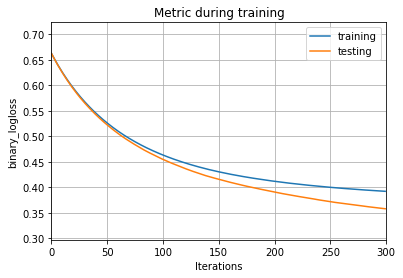

Confusion Matrix: 
 [[21101  3366]
 [ 3048 12279]]
The AUC score is:  0.9192897473995523
The Binary_Log_Loss is:  0.3580074380828356


In [24]:
#parameters are X_train, X_test, y_train, y_test, X_eval = None, y_eval = None, eval_set = False, output_probabilities = True, n_estimators = 300, early_stopping_rounds = 50, num_leaves = 1000, 
#reg_alpha = 0, reg_lambda = 0.5, subsample = 0.5, learning_rate = 0.01, verbose = 200). All parameter that is not specified here are the default parameters of the lightgbm model.

lightgbm_model = predict_lightgbm(X_train, X_test, y_train, y_test, 
                         output_probabilities = True,
                         n_estimators = 300, 
                         early_stopping_rounds = 50, 
                         num_leaves = 1000,
                         reg_alpha = 0,
                         reg_lambda = 0.5,
                         subsample = 0.5, 
                         learning_rate = 0.01,
                         verbose = 200)

#### Model Performance

Classification Accuracy:  0.7933982547110155
Classification Error: 	 0.20660174528898445
Recall:  		 0.6850523267294149
Precision: 		 0.7546950910013777
F1 score: 		 0.7181893458459839
AUC: 			 0.8846233294727821
Cross Entropy: 		 0.41213648762970256


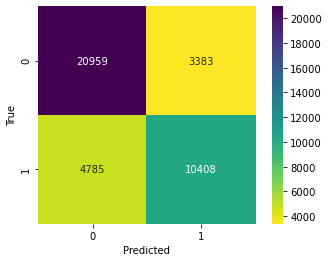

In [112]:
#Predictions and Classification Report
lgbm_pred = lightgbm_model.predict(X_test)
# Probabilities are returned for each class, unfortunately without the class names
lgbm_pred_prob = lightgbm_model.predict_proba(X_test)
lgbm_pred_prob = lgbm_pred_prob[:,1]

print('Classification Accuracy: ',   metrics.accuracy_score(y_test, lgbm_pred))
print('Classification Error: \t',    1 - metrics.accuracy_score(y_test, lgbm_pred))
print("Recall:  \t\t",               metrics.recall_score(y_test, lgbm_pred))
print("Precision: \t\t",             metrics.precision_score(y_test, lgbm_pred))
print("F1 score: \t\t",              metrics.f1_score(y_test, lgbm_pred))
print('AUC: \t\t\t',                 metrics.roc_auc_score(y_test, lgbm_pred_prob))
print('Cross Entropy: \t\t',       metrics.log_loss(y_test, lgbm_pred_prob))

cm = confusion_matrix(y_test,lgbm_pred)
ax = sns.heatmap(cm,cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

### LightGBM vs Baseline Heuristic Model 

#### LightGBM Model

In [ ]:
#load LightGBM model 
filename = 'lightgbm_model_test89.pkl'
with open(filename, 'rb') as file:
    lgbm_m = pickle.load(file)

#### Week 89 data 

In [52]:
test_89 = test[test['week'] == 89]

In [56]:
X_test_89 = test_89.drop(['product_bought', 'shopper', 'product', 'purchase_w/o_dis', 'no_purchase_w_dis', 'discount_effect', 'week_basket_size', 'week_basket_value', 'discount_offered'], axis = 1)

#### Light GBM - Coupon Recommendations for Week 89 

In [ ]:
import importlib
importlib.reload(module_coupon_assignment)

In [57]:
# creating test data including prediction for various discounts d e {15,20,25,30}
X_test_d15, X_test_d20, X_test_d25, X_test_d30 = module_coupon_assignment.get_test_discounts(X_test_89)

In [58]:
# creating predictions for each discount {15,20,25,30}
pred_d15, pred_d20, pred_d25, pred_d30 = module_coupon_assignment.predictions(lgbm_m, X_test_d15, X_test_d20, X_test_d25, X_test_d30)

In [59]:
# merge predictions back to original test data sets for discounts 
X_test_d15, X_test_d20, X_test_d25, X_test_d30 = module_coupon_assignment.merge_predictions(test_89, X_test_d15, X_test_d20, X_test_d25, X_test_d30, pred_d15, pred_d20, pred_d25, pred_d30)

In [70]:
# assign top 5 coupons via revenue maximization 
lgbm_coupons = module_coupon_assignment.coupon_assignment(X_test_d15, X_test_d20, X_test_d25, X_test_d30)

In [71]:
lgbm_coupons.head(n=10)

,shopper,week,coupon,product,discount
0,0,89,0,184,15
1,0,89,1,71,15
2,0,89,2,130,15
3,0,89,3,91,15
4,0,89,4,87,15
5,1,89,0,63,15
6,1,89,1,78,15
7,1,89,2,165,15
8,1,89,3,200,15
9,1,89,4,220,25


#### Baseline Heuristic Model - Coupons Recommendations for Week 89

The baseline heuristic model applies the same logic irregardless of which week is being predicted, thus we can set week to an arbitrary value, here 89. 

In [61]:
baseline_coupons = heur_idx.copy()
baseline_coupons['week'] = 89
baseline_coupons.head(n=10)

,shopper,week,coupon,product,discount
0,0,89,0,185,30
1,0,89,1,16,25
2,0,89,2,207,20
3,0,89,3,179,15
4,0,89,4,214,15
5,1,89,0,75,30
6,1,89,1,157,25
7,1,89,2,165,20
8,1,89,3,220,15
9,1,89,4,53,15


#### Comparison: LGBM vs Baseline Heuristic Model

In [78]:
test_89_s = test_89[['shopper', 'week', 'product', 'discount']]

In [79]:
test_89_s = test_89_s[test_89_s['discount'] > 0]

In [83]:
shopper_prods_lgbm = pd.merge(lgbm_coupons, test_89_s, how='inner', on=(['shopper','product']))

In [88]:
shopper_prods_baseline = pd.merge(baseline_coupons, test_89_s, how='inner', on=(['shopper','product']))

In [87]:
print('LGBM: Coupon Classification Accuracy: ',   (len(shopper_prods_lgbm)/len(test_89_s)))

LGBM: Coupon Classification Accuracy:  0.06253126563281641


In [89]:
print('Baseline Heuristic Model: Coupon Classification Accuracy: ',   (len(shopper_prods_baseline)/len(test_89_s)))

Baseline Heuristic Model: Coupon Classification Accuracy:  0.032416208104052026


**The LGBM coupon solution is 93% better than the baseline solution.**

## Final Prediction

In [26]:
filename = 'lightgbm_model_final.pkl'
with open(filename, 'rb') as file:
    model = pickle.load(file)

In [106]:
import module_coupon_assignment 
#from module_coupon_assignment import coupon_assigmnet 
import module_week90_generate_dataset
from module_week90_generate_dataset import week90_generate_dataset

import importlib
importlib.reload(module_coupon_assignment)

<module 'coupon_assignment' from '/Users/Bisa/Documents/Studium/Masterstudium/5_Semester/MLiM/FinalAssignment/coupon_assignment.py'>

### Load Trained LightGBM

In [28]:
filename = 'lightgbm_model_final.pkl'
lightgbm_model = module_coupon_assignment.load_model(filename)

### Generate Data Set for Week90 to Make Final Prediction

In [60]:
# read week 90 code
# for example 
X_test_90_all = week90_generate_dataset(path_datasets) # by funciton call - uses week90_gerate_dataset() 
X_test_90 = X_test_90_all.drop(['product_bought', 'shopper', 'product'], axis = 1) 

X_test_90 = pd.read_parquet("X_test_90.parquet") # by reading csv 

#the variables price and discount will be added to the data set by the logical layer

The dataframes should be named: 
baskets.parquet, 
coupons.parquet, 
df_negative_samples.parquet, 
product_categories.csv, 
avg_no_weeks_between_two_purchases.parquet, 
lags.parquet and 
purchase_temporal_distribution.parquet

The data set for week 90 is generated and saved as a parquet file to: /Users/Bisa/Documents/Studium/Masterstudium/5_Semester/MLiM/datasets


### Coupon Recommendation 

In [107]:
# creating test data including prediction for various discounts d e {15,20,25,30}
X_test_d15, X_test_d20, X_test_d25, X_test_d30 = module_coupon_assignment.get_test_discounts(X_test_90)

In [108]:
# creating predictions for each discount {15,20,25,30}
pred_d15, pred_d20, pred_d25, pred_d30 = module_coupon_assignment.predictions(lightgbm_model, X_test_d15, X_test_d20, X_test_d25, X_test_d30)

In [109]:
# merge predictions back to original test data sets for discounts 
X_test_d15, X_test_d20, X_test_d25, X_test_d30 = module_coupon_assignment.merge_predictions(X_test_90_all, X_test_d15, X_test_d20, X_test_d25, X_test_d30, pred_d15, pred_d20, pred_d25, pred_d30)

In [110]:
# assign top 5 coupons via revenue maximization 
top5coupons = module_coupon_assignment.coupon_assignment(X_test_d15, X_test_d20, X_test_d25, X_test_d30)

In [111]:
top5coupons.head(n = 10)

,shopper,week,coupon,product,discount
0,0,90,0,56,15
1,0,90,1,16,15
2,0,90,2,116,15
3,0,90,3,38,15
4,0,90,4,244,15
5,1,90,0,117,15
6,1,90,1,63,15
7,1,90,2,116,15
8,1,90,3,111,15
9,1,90,4,36,15


### Save Prediction

In [105]:
#save final prediction
top5coupons.to_parquet(path_datasets + '/coupon_index.parquet')